<a href="https://colab.research.google.com/github/PrajwalRedee/Australia-Rainfall-Prediction/blob/main/Logistic_regression_rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QUESTION: The [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset contains about 10 years of daily weather observations from numerous Australian weather stations. 

As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

In [1]:
!pip install opendatasets --upgrade --quiet


In [2]:
import opendatasets as od


In [3]:
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'


In [4]:
od.download(dataset_url)


Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [5]:
import os



In [6]:
data_dir = './weather-dataset-rattle-package'


In [7]:
os.listdir(data_dir)


['weatherAUS.csv']

In [8]:
train_csv = data_dir + '/weatherAUS.csv'


In [9]:
import pandas as pd


In [10]:
raw_df = pd.read_csv(train_csv)


In [11]:
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [12]:
raw_df.shape

(145460, 23)

In [13]:
raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Lets remove the null values from the target coumn

In [14]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)


## Exploratory Data Analysis and Visualization


In [15]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [16]:
px.histogram(raw_df, x='Location', title='Location vs. Rainy Days', color='RainToday')


In this graph we can see the number of counts it has rained or not for each location


In [17]:
px.histogram(raw_df, 
             x='Temp3pm', 
             title='Temperature at 3 pm vs. Rain Tomorrow', 
             color='RainTomorrow')

From the above graph we can tell that the probablity of rain tomorrow is high when the temperature is low

In [18]:
px.histogram(raw_df, 
             x='RainTomorrow', 
             color='RainToday', 
             title='Rain Tomorrow vs. Rain Today')


We can say that the probablity of rain tomorrow is high when is no rain today but there are lot of other factors involved

In [19]:
px.scatter(raw_df.sample(2000), 
           title='Min Temp. vs Max Temp.',
           x='MinTemp', 
           y='MaxTemp', 
           color='RainToday')

Rain today is Yes when the max temp and min temp are close to each other

In [20]:
px.scatter(raw_df.sample(2000), 
           title='Temp (3 pm) vs. Humidity (3 pm)',
           x='Temp3pm',
           y='Humidity3pm',
           color='RainTomorrow')

Rain tomorrow is No when temp is high and humidity and low
and rain tomorrow is Yes when humidity is high and temp is low

In [21]:
from sklearn.model_selection import train_test_split


In [22]:
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [23]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (84471, 23)
val_df.shape : (28158, 23)
test_df.shape : (28158, 23)


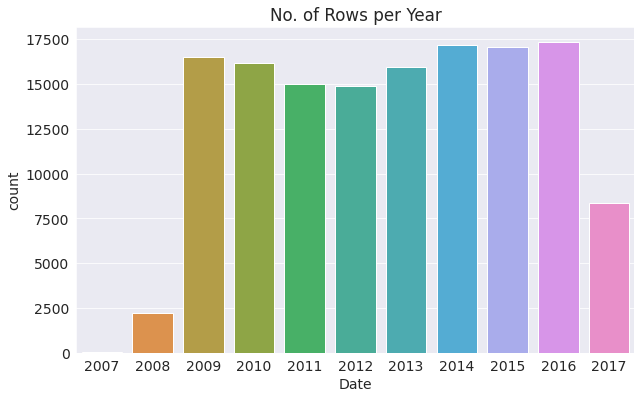

In [24]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [25]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [26]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)


train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


### Input and Target variable

In [27]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [28]:
print(input_cols)


['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [29]:
target_col


'RainTomorrow'

In [30]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [31]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [32]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Lets check the numeric columns and categorical columns

In [33]:
import numpy as np


In [34]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [35]:
numeric_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [36]:
train_inputs[numeric_cols].describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.000000,97801.000000,97988.000000,61657.000000,57942.000000,91160.000000,97114.000000,96919.000000,96936.000000,96872.000000,88876.000000,88857.000000,63000.000000,61966.000000,97414.000000,97392.000000
mean,12.007831,23.022202,2.372935,5.289991,7.609004,40.215873,14.092263,18.764608,68.628745,51.469547,1017.513734,1015.132352,4.302952,4.410677,16.835126,21.540138
std,6.347175,6.984397,8.518819,3.952010,3.788813,13.697967,8.984203,8.872398,19.003097,20.756113,7.072510,6.997072,2.866634,2.693370,6.404586,6.831612
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-5.900000,-5.100000
25%,7.500000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.800000,1010.400000,1.000000,2.000000,12.200000,16.600000
50%,11.800000,22.400000,0.000000,4.600000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.500000,1015.100000,5.000000,5.000000,16.600000,20.900000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.300000,1019.900000,7.000000,7.000000,21.400000,26.200000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000


In [37]:
train_inputs[categorical_cols].nunique()


Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Dealing with missing numbers

In [38]:
from sklearn.impute import SimpleImputer


Replacing the missing values with average value of the column

In [39]:
imputer = SimpleImputer(strategy = 'mean')


Lets check the missing values

In [40]:
train_inputs[numeric_cols].isna().sum()


MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

In [41]:
imputer.fit(raw_df[numeric_cols])


SimpleImputer()

In [42]:
list(imputer.statistics_)


[12.18482386562048,
 23.235120301822324,
 2.349974074310839,
 5.472515506887154,
 7.630539861047281,
 39.97051988882308,
 13.990496092519967,
 18.631140782316862,
 68.82683277087672,
 51.44928834695453,
 1017.6545771543717,
 1015.2579625879797,
 4.431160817585808,
 4.499250233195188,
 16.98706638787991,
 21.69318269001107]

In [43]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [44]:
train_inputs[numeric_cols].isna().sum()


MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## Scaling Numeric Features

Using MinMaxScaler 

In [45]:
from sklearn.preprocessing import MinMaxScaler


In [46]:
scaler = MinMaxScaler()


In [47]:
scaler.fit(raw_df[numeric_cols])


MinMaxScaler()

In [48]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [49]:
train_inputs[numeric_cols].describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000
mean,0.483689,0.525947,0.006396,0.036949,0.525366,0.265107,0.108395,0.215668,0.686309,0.514693,0.612014,0.608705,0.483192,0.493693,0.507089,0.517103
std,0.149458,0.131904,0.022962,0.021628,0.200931,0.102420,0.068800,0.101424,0.189008,0.206376,0.111335,0.106611,0.255486,0.238028,0.134722,0.130726
min,0.000000,0.013233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030400,0.000000,0.000000,0.027426,0.005758
25%,0.377358,0.429112,0.000000,0.026207,0.517241,0.193798,0.053846,0.149425,0.570000,0.370000,0.543802,0.540800,0.333333,0.333333,0.409283,0.422265
50%,0.478774,0.514178,0.000000,0.037741,0.526244,0.255814,0.100000,0.218391,0.690000,0.520000,0.614125,0.610527,0.492351,0.499917,0.502110,0.506718
75%,0.591981,0.618147,0.002156,0.038621,0.634483,0.310078,0.146154,0.275862,0.830000,0.650000,0.682645,0.675200,0.666667,0.666667,0.601266,0.604607
max,1.000000,1.000000,1.000000,0.568276,0.986207,1.000000,0.669231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988484


Converting categorical data

In [50]:
raw_df[categorical_cols].nunique()


Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [51]:
from sklearn.preprocessing import OneHotEncoder


In [52]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')


In [53]:
encoder.fit(raw_df[categorical_cols])


OneHotEncoder(handle_unknown='ignore', sparse=False)

In [54]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [55]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented 

In [56]:
test_inputs


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.801512,0.000000,0.037741,0.526244,ENE,0.372093,NaN,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037741,0.526244,SSE,0.341085,SSE,SE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037741,0.526244,ENE,0.325581,ESE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.538752,0.042049,0.037741,0.526244,SSE,0.255814,SE,SSE,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2502,Albury,0.566038,0.523629,0.018329,0.037741,0.526244,ENE,0.193798,SE,SSE,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,0.283019,0.502836,0.000000,0.037741,0.526244,E,0.193798,ESE,E,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145455,Uluru,0.266509,0.533081,0.000000,0.037741,0.526244,E,0.193798,SE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145456,Uluru,0.285377,0.568998,0.000000,0.037741,0.526244,NNW,0.124031,SE,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
145457,Uluru,0.327830,0.599244,0.000000,0.037741,0.526244,N,0.240310,SE,WNW,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Training the Model

In [57]:
from sklearn.linear_model import LogisticRegression


In [58]:
model = LogisticRegression(solver='liblinear')


In [59]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)


LogisticRegression(solver='liblinear')

In [60]:
weight_df = pd.DataFrame({
    'features' : (numeric_cols + encoded_cols),
    'weight' : model.coef_.tolist()[0]
})

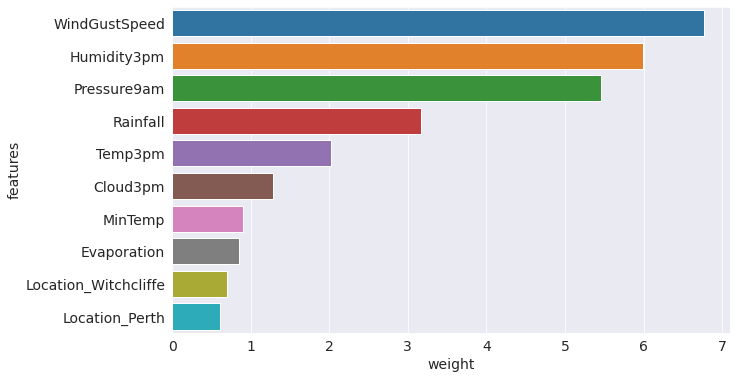

In [61]:
sns.barplot(data=weight_df.sort_values('weight',ascending=False).head(10), x='weight', y='features')

In [62]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [63]:
train_preds = model.predict(X_train)


In [64]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [65]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94401112, 0.05598888],
       [0.94074168, 0.05925832],
       [0.96093614, 0.03906386],
       ...,
       [0.98749119, 0.01250881],
       [0.98334685, 0.01665315],
       [0.87453486, 0.12546514]])

To check the accuracy of the model on the training set

In [66]:
from sklearn.metrics import accuracy_score


In [67]:
accuracy_score(train_targets, train_preds)


0.8519206433440829

The accuracy of the model is 85.1%

In [68]:
from sklearn.metrics import confusion_matrix


In [69]:
confusion_matrix(train_targets, train_preds, normalize='true')


array([[0.94621341, 0.05378659],
       [0.4776585 , 0.5223415 ]])

Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given st of inputs.

In [70]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 85.19%


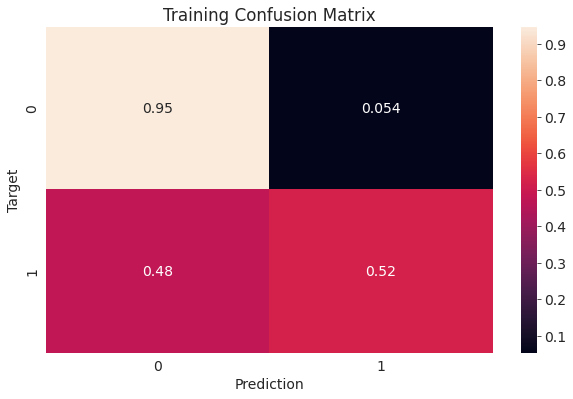

In [71]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')


Let's compute the model's accuracy on the validation and test sets too.



Accuracy: 85.40%


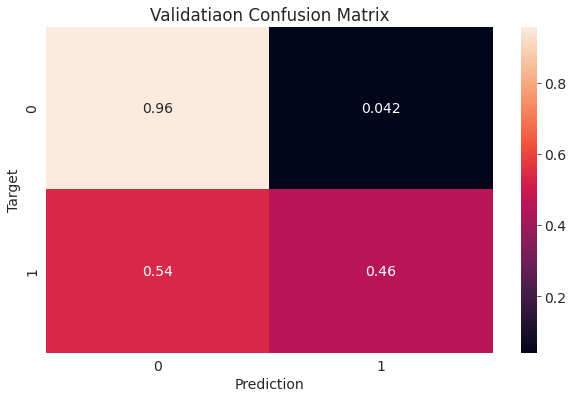

In [72]:
val_preds = predict_and_plot(X_val, val_targets, 'Validatiaon')


Accuracy: 84.20%


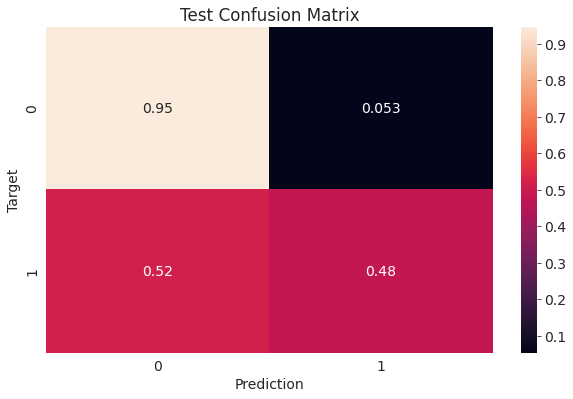

In [73]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')


## Lets Train the model using Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier


In [75]:
model = DecisionTreeClassifier(random_state=42)


In [76]:
model.fit(X_train, train_targets)


DecisionTreeClassifier(random_state=42)

A model has been created. Now lets check the accuracy

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix


In [78]:
train_preds = model.predict(X_train)


In [79]:
accuracy_score(train_targets, train_preds)


0.9999795893374699

In [80]:
model.score(X_val, val_targets)


0.7936684416876353

Here we can see that the accuracy for the validation set is only 79% and for training set is 99%

Lets check the feature importance

In [81]:
model.feature_importances_


array([3.72348864e-02, 3.02750170e-02, 4.46807871e-02, 2.31016443e-02,
       4.74029876e-02, 6.02158346e-02, 2.59596261e-02, 2.87123098e-02,
       3.72718924e-02, 2.78696714e-01, 3.74751640e-02, 6.22463592e-02,
       1.50293521e-02, 1.72695492e-02, 3.51997396e-02, 3.28171151e-02,
       2.07437921e-03, 1.64079963e-03, 1.01783054e-03, 6.88212657e-04,
       1.48034667e-03, 1.10335980e-03, 1.19280342e-03, 1.77001797e-03,
       8.18956871e-04, 1.30986391e-03, 8.00314193e-04, 2.03677225e-03,
       1.38645663e-03, 4.84888047e-04, 6.08349928e-04, 1.26483304e-03,
       1.45258514e-04, 1.50514431e-03, 1.07182434e-03, 1.44829853e-03,
       9.12938347e-04, 8.15936194e-04, 1.26468932e-03, 1.49092396e-03,
       6.60526489e-04, 7.09652768e-04, 1.02344514e-03, 1.54844869e-03,
       1.31824900e-03, 6.07286685e-04, 5.04774518e-04, 1.50976724e-03,
       1.36782184e-03, 2.12844007e-03, 1.24769141e-03, 1.92047622e-03,
       1.46145581e-03, 2.12670031e-03, 1.36401119e-03, 4.10431985e-04,
      

In [82]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [83]:
importance_df.head(10)


,feature,importance
9,Humidity3pm,0.278697
11,Pressure3pm,0.062246
5,WindGustSpeed,0.060216
4,Sunshine,0.047403
2,Rainfall,0.044681
10,Pressure9am,0.037475
8,Humidity9am,0.037272
0,MinTemp,0.037235
14,Temp9am,0.035200
15,Temp3pm,0.032817


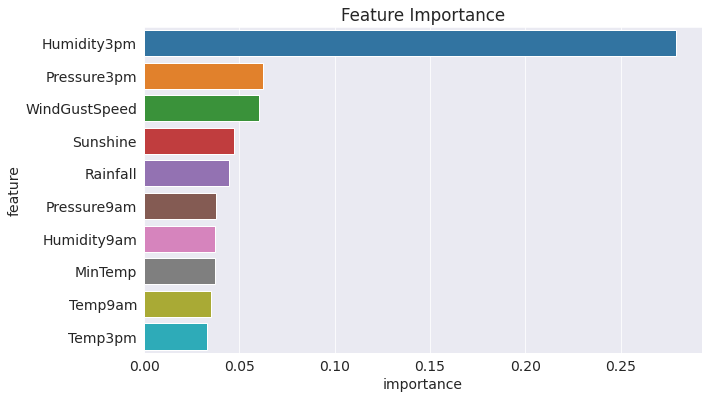

In [84]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

We can see the top 10 features that are importnant

## Hyperparameter Tuning

Lets take a look on max_depth and max_leaf_nodes

In [85]:
model.max_depth

In [86]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Accuracy': train_acc, 'Validation Accuracy': val_acc}

In [87]:
df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [88]:
df

,Max Depth,Training Accuracy,Validation Accuracy
0,1,0.818059,0.823512
1,2,0.823070,0.829305
2,3,0.831592,0.834806
3,4,0.837847,0.838376
4,5,0.842756,0.841887
5,6,0.846869,0.844169
6,7,0.850941,0.845398
7,8,0.855186,0.846158
8,9,0.860565,0.845456
9,10,0.868198,0.845222


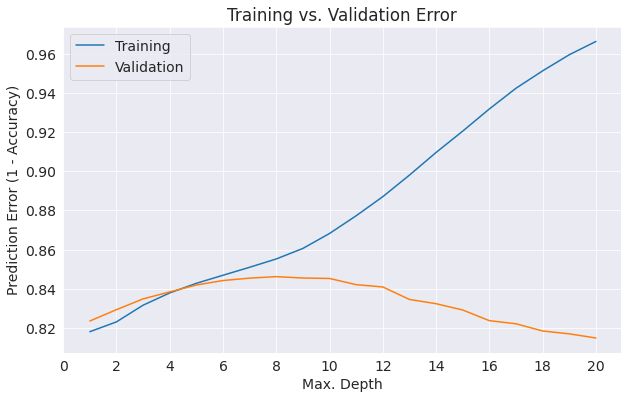

In [89]:
plt.figure()
plt.plot(df['Max Depth'], df['Training Accuracy'])
plt.plot(df['Max Depth'], df['Validation Accuracy'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

We need to find the optimal fit

In [90]:
model = DecisionTreeClassifier(max_depth=8, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8461583474749839

## Conclusion

We now found out the best max_depth = 8 and the accuracy is 84.6%